In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath("../../"))
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from src.config import Config, load_spreadsheet
from src.rag import (
    ChromaSlideStore,
    HyperbolicScorer,
    MinScorer,
    PresentationRetriever,
    ScorerTypes,
)
from src.eval.eval_mlflow import MlflowConfig, RAGEvaluatorMlflow
from src.rag.storage import LLMPresentationRetriever

import mlflow

In [3]:
# Mlflow setup logging
mlflow.langchain.autolog()

# Setup components
project_config = Config()
llm = project_config.model_config.load_vsegpt(model="openai/gpt-4o-mini")
embeddings = project_config.embedding_config.load_vsegpt()
# embeddings = project_config.embedding_config.load_openai()

storage = ChromaSlideStore(collection_name="pres1", embedding_model=embeddings)
retriever = LLMPresentationRetriever(storage=storage, llm=llm, n_contexts=10, n_pages=3)

db_path = project_config.navigator.processed / "eval" / "runs" / "mlruns.db"
artifacts_path = project_config.navigator.processed / "eval" / "artifacts"
eval_config = MlflowConfig(
    retriever = retriever,
    experiment_name="PresRetrieve_7",
    metrics=["presentationmatch", "llmrelevance"],
    scorers=[MinScorer(), HyperbolicScorer()],

)

evaluator = RAGEvaluatorMlflow(
    config=eval_config,
    llm=llm
)

In [11]:
from IPython.display import display
# Load questions
sheet_id = os.environ["BENCHMARK_SPREADSHEET_ID"]
gids = {
    "NoAnswer": "1219206941"
}
df = evaluator.load_questions_from_sheet(sheet_id, gid=gids["NoAnswer"])

df_eval = df.sample(5)
df_eval = df.copy()
display(df_eval)

,pres_name,question,page,content,comment
0,NaN,Презентация про космонавтов,,NaN,NaN
1,NaN,Презентация про экономику Китая,,NaN,NaN
2,NaN,Зоомагазины,,NaN,NaN
3,NaN,The capital of Great Britain,,NaN,NaN
4,NaN,Обучение LLM на CPU,,NaN,NaN
5,NaN,Фото кабриолета,,NaN,NaN
6,NaN,История Российской Империи,,NaN,NaN


In [12]:
df = evaluator.load_questions_from_sheet(sheet_id)
df_eval = df.sample(20)

In [13]:
import nest_asyncio
nest_asyncio.apply()
# Run evaluation
evaluator.run_evaluation(df_eval)



Processing questions (max 5 concurrent):  65%|██████▌   | 13/20 [02:11<01:02,  8.87s/it]Failed to process question 2: Error code: 429 - {'error': {'message': 'Rate-limit error: You send more than 1 request per 1.0 second. Try later.', 'code': 429}}
Failed to process question 14: Error code: 429 - {'error': {'message': 'Rate-limit error: You send more than 1 request per 1.0 second. Try later.', 'code': 429}}
Processing questions (max 5 concurrent): 100%|██████████| 20/20 [02:56<00:00,  8.85s/it]


## PLotting Results

### Scorers Evaluation

In [4]:
exp_name = "PresRetrieve_69"

df_runs_full = mlflow.search_runs(
    experiment_names=[exp_name],
)
print(df_runs_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype              
---  ------                                   --------------  -----              
 0   run_id                                   16 non-null     object             
 1   experiment_id                            16 non-null     object             
 2   status                                   16 non-null     object             
 3   artifact_uri                             16 non-null     object             
 4   start_time                               16 non-null     datetime64[ns, UTC]
 5   end_time                                 16 non-null     datetime64[ns, UTC]
 6   metrics.mean_presentationcount           16 non-null     float64            
 7   metrics.mean_presentationidx             16 non-null     float64            
 8   metrics.mean_bestchunkmatch              16 non-null     float64        

In [5]:
columns = ["tags.mlflow.runName", "params.preprocessing"] + [c for c in df_runs_full.columns if "metrics." in c]
df_runs = df_runs_full[columns]
df_runs.columns = [c.split(".")[-1] for c in df_runs.columns]

df_runs.loc[:, "scorer"] = df_runs["runName"].apply(lambda x: x.split("_")[1])
df_runs.loc[:, "preprocessing"] = df_runs["preprocessing"].apply(lambda x: "Regex" if "Regex" in x else x)

df_runs

/tmp/ipykernel_108891/2158357613.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs.loc[:, "scorer"] = df_runs["runName"].apply(lambda x: x.split("_")[1])


,runName,preprocessing,mean_presentationcount,mean_presentationidx,mean_bestchunkmatch,mean_pagefound,mean_pagematch,error_rate,mean_presentationmatch,n_questions,mean_presentationfound,scorer
0,scorer_linear_1-1.0_3-0.9_8-0.7__retriever_pre...,None,10.925743,2.168478,0.212871,0.787129,0.59901,0.0,0.618812,202.0,0.910891,linear
1,scorer_step_1-1.0_3-0.9_8-0.7__retriever_prese...,None,10.925743,2.271739,0.198020,0.787129,0.59901,0.0,0.574257,202.0,0.910891,step
2,scorer_exponential_a0.7_w1.7_s2.8__retriever_p...,None,10.925743,2.407609,0.217822,0.787129,0.59901,0.0,0.608911,202.0,0.910891,exponential
3,scorer_exponentialweighted_a0.7_w1.7_s2.8__ret...,None,10.925743,2.733696,0.202970,0.787129,0.59901,0.0,0.544554,202.0,0.910891,exponentialweighted
4,scorer_hyperbolicweighted_k2.0_p3.0__retriever...,None,10.925743,2.065217,0.212871,0.787129,0.59901,0.0,0.673267,202.0,0.910891,hyperbolicweighted
5,scorer_weighted__retriever_presentationretriev...,None,10.925743,2.456522,0.212871,0.787129,0.59901,0.0,0.559406,202.0,0.910891,weighted
6,scorer_exponential_a0.7_w1.7_s2.8__retriever_p...,None,10.925743,2.407609,0.217822,0.787129,0.59901,0.0,0.608911,202.0,0.910891,exponential
7,scorer_min__retriever_presentationretriever__p...,None,10.925743,2.211957,0.202970,0.787129,0.59901,0.0,0.628713,202.0,0.910891,min
8,scorer_linear_1-1.0_3-0.9_8-0.7__retriever_pre...,Regex,9.103960,1.967033,0.336634,0.787129,0.59901,0.0,0.623762,202.0,0.900990,linear
9,scorer_step_1-1.0_3-0.9_8-0.7__retriever_prese...,Regex,9.103960,1.901099,0.351485,0.787129,0.59901,0.0,0.633663,202.0,0.900990,step


/tmp/ipykernel_108891/2369639957.py:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  plot = sns.barplot(


[Text(0.5, 0, 'Presentation Match'),
 Text(0, 0.5, 'Scorer'),
 Text(0.5, 1.0, 'Testing Presentation Match \nfor Different Scorers and Preprocessings')]

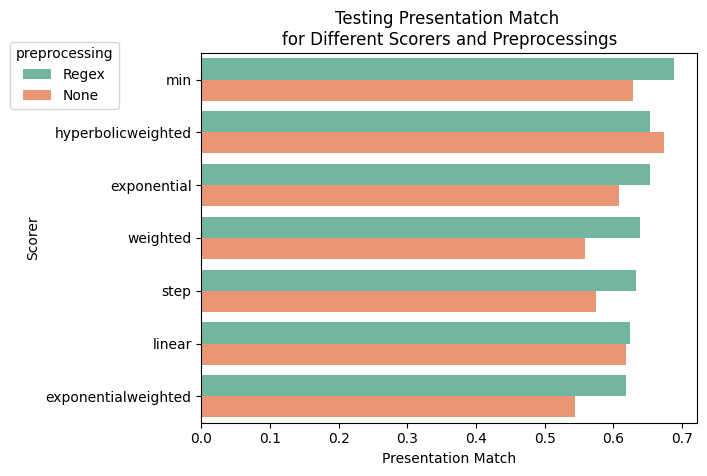

In [6]:
import seaborn as sns

plot = sns.barplot(
    df_runs.sort_values(by=["mean_presentationmatch"], ascending=False),
    x="mean_presentationmatch",
    y="scorer",
    hue="preprocessing",
    palette=sns.color_palette("Set2"),
)
sns.move_legend(plot, "upper left", bbox_to_anchor=(-0.4, 1.05))
plot.set(xlabel="Presentation Match", ylabel="Scorer", title="Testing Presentation Match \nfor Different Scorers and Preprocessings")


In [7]:
df_runs.groupby("preprocessing")["mean_presentationfound"].mean()

preprocessing
None     0.910891
Regex    0.900990
Name: mean_presentationfound, dtype: float64

### LLM-metric

In [8]:
exp_name = "PresRetrieve_69_llm"

df_runs_full = mlflow.search_runs(
    experiment_names=[exp_name],
)

df_runs_full = mlflow.search_runs(
    experiment_names=[exp_name],
)
print(df_runs_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype              
---  ------                                   --------------  -----              
 0   run_id                                   10 non-null     object             
 1   experiment_id                            10 non-null     object             
 2   status                                   10 non-null     object             
 3   artifact_uri                             10 non-null     object             
 4   start_time                               10 non-null     datetime64[ns, UTC]
 5   end_time                                 10 non-null     datetime64[ns, UTC]
 6   metrics.mean_presentationcount           10 non-null     float64            
 7   metrics.mean_presentationidx             10 non-null     float64            
 8   metrics.mean_bestchunkmatch              10 non-null     float64         

In [18]:
df_runs_full["run_id"]

0    660c3ebd3cd145e89815eb31c33c125a
1    9b971822ff3f47978a66b27c323e1ff5
2    8e395bc634de4fdc8d5675635810ce43
3    d974d8d0ed414efe86188db488c7f3b0
4    7199da4de00b428c8f744fb513ba1eeb
5    73ca49f2e580489193e38c3573f68912
6    fdb69b2939ca40e68304fa18fa17aa3e
7    5bbf58bb439a40d4b4bd4b7762afd939
8    f088c46ec3864d678527389eedd3c2e9
9    b97c8d60d8314d958209ee601a070147
Name: run_id, dtype: object

In [9]:
columns = ["tags.mlflow.runName", "params.preprocessing", "artifact_uri"] + [c for c in df_runs_full.columns if "metrics." in c]
df_runs = df_runs_full[columns]
df_runs.columns = [c.split(".")[-1] for c in df_runs.columns]

df_runs.loc[:, "scorer"] = df_runs["runName"].apply(lambda x: x.split("_")[1])
df_runs.loc[:, "preprocessing"] = df_runs["preprocessing"].apply(lambda x: "Regex" if "Regex" in x else x)

df_runs

/tmp/ipykernel_108891/1726606477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs.loc[:, "scorer"] = df_runs["runName"].apply(lambda x: x.split("_")[1])


,runName,preprocessing,artifact_uri,mean_presentationcount,mean_presentationidx,mean_bestchunkmatch,mean_pagefound,mean_llmrelevance,mean_pagematch,error_rate,mean_presentationmatch,n_questions,mean_presentationfound,scorer
0,scorer_exponentialweighted_a0.7_w1.7_s2.8__ret...,None,file:///home/groot/Desktop/projects/global/Pre...,10.896040,2.836957,0.202970,0.782178,6.594059,0.594059,0.0,0.539604,202.0,0.910891,exponentialweighted
1,scorer_hyperbolicweighted_k2.0_p3.0__retriever...,None,file:///home/groot/Desktop/projects/global/Pre...,10.900990,2.092391,0.212871,0.782178,7.024752,0.594059,0.0,0.668317,202.0,0.910891,hyperbolicweighted
2,scorer_weighted__retriever_presentationretriev...,None,file:///home/groot/Desktop/projects/global/Pre...,10.896040,2.548913,0.212871,0.782178,6.465347,0.594059,0.0,0.554455,202.0,0.910891,weighted
3,scorer_exponential_a0.7_w1.7_s2.8__retriever_p...,None,file:///home/groot/Desktop/projects/global/Pre...,10.896040,2.510870,0.217822,0.782178,6.826733,0.594059,0.0,0.603960,202.0,0.910891,exponential
4,scorer_min__retriever_presentationretriever__p...,None,file:///home/groot/Desktop/projects/global/Pre...,10.896040,2.304348,0.202970,0.782178,6.693069,0.594059,0.0,0.623762,202.0,0.910891,min
5,scorer_exponentialweighted_a0.7_w1.7_s2.8__ret...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.113861,2.043956,0.336634,0.787129,6.623762,0.599010,0.0,0.613861,202.0,0.900990,exponentialweighted
6,scorer_hyperbolicweighted_k2.0_p3.0__retriever...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.108911,2.027473,0.361386,0.787129,6.886139,0.599010,0.0,0.653465,202.0,0.900990,hyperbolicweighted
7,scorer_weighted__retriever_presentationretriev...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.108911,1.983516,0.366337,0.787129,6.896040,0.599010,0.0,0.638614,202.0,0.900990,weighted
8,scorer_exponential_a0.7_w1.7_s2.8__retriever_p...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.113861,1.923077,0.346535,0.787129,6.846535,0.599010,0.0,0.653465,202.0,0.900990,exponential
9,scorer_min__retriever_presentationretriever__p...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.118812,1.873626,0.361386,0.787129,7.034653,0.599010,0.0,0.688119,202.0,0.900990,min


/tmp/ipykernel_108891/3721462382.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  plot = sns.barplot(


[Text(0.5, 0, 'LLM Relevance'),
 Text(0, 0.5, 'Scorer'),
 Text(0.5, 1.0, 'Testing LLM Relevance \nfor Different Scorers and Preprocessings')]

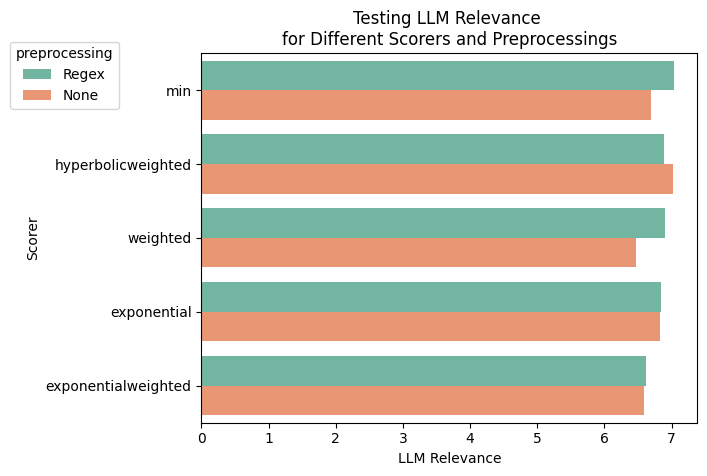

In [10]:
col = "mean_llmrelevance"
plot = sns.barplot(
    df_runs.sort_values(by=[col], ascending=False),
    x=col,
    y="scorer",
    hue="preprocessing",
    palette=sns.color_palette("Set2"),
)
sns.move_legend(plot, "upper left", bbox_to_anchor=(-0.4, 1.05))
plot.set(xlabel="LLM Relevance", ylabel="Scorer", title="Testing LLM Relevance \nfor Different Scorers and Preprocessings")

In [42]:
artifact_uri = df_runs["artifact_uri"]
print(*artifact_uri, sep="\n")

file:///home/groot/Desktop/projects/global/PresRAG/presentation-rag/data/processed/eval/artifacts/660c3ebd3cd145e89815eb31c33c125a/artifacts
file:///home/groot/Desktop/projects/global/PresRAG/presentation-rag/data/processed/eval/artifacts/9b971822ff3f47978a66b27c323e1ff5/artifacts
file:///home/groot/Desktop/projects/global/PresRAG/presentation-rag/data/processed/eval/artifacts/8e395bc634de4fdc8d5675635810ce43/artifacts
file:///home/groot/Desktop/projects/global/PresRAG/presentation-rag/data/processed/eval/artifacts/d974d8d0ed414efe86188db488c7f3b0/artifacts
file:///home/groot/Desktop/projects/global/PresRAG/presentation-rag/data/processed/eval/artifacts/7199da4de00b428c8f744fb513ba1eeb/artifacts
file:///home/groot/Desktop/projects/global/PresRAG/presentation-rag/data/processed/eval/artifacts/73ca49f2e580489193e38c3573f68912/artifacts
file:///home/groot/Desktop/projects/global/PresRAG/presentation-rag/data/processed/eval/artifacts/fdb69b2939ca40e68304fa18fa17aa3e/artifacts
file:///home/

In [ ]:
from pathlib import Path
import pandas as pd
artifact_uri = df_runs["artifact_uri"][1]
print(artifact_uri)
artifact_path = Path(artifact_uri.split("file://")[1])
print(artifact_path)

csv_paths = list(artifact_path.rglob("*.*"))
csv_path = csv_paths[0]
run_id = str(artifact_path).split("/")[-2]
print(run_id)

df_run = pd.read_csv(csv_path)
df_run.info()

# set(df_runs_full["run_id"]).intersection(set(hash_names))

file:///home/groot/Desktop/projects/global/PresRAG/presentation-rag/data/processed/eval/artifacts/9b971822ff3f47978a66b27c323e1ff5/artifacts
/home/groot/Desktop/projects/global/PresRAG/presentation-rag/data/processed/eval/artifacts/9b971822ff3f47978a66b27c323e1ff5/artifacts
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   question                              202 non-null    object 
 1   expected_content_type                 202 non-null    object 
 2   expected_presentation                 202 non-null    object 
 3   expected_pages                        148 non-null    object 
 4   retrieved_presentations               202 non-null    object 
 5   retrieved_pages                       202 non-null    object 
 6   best_chunk_type                       202 non-null    object 
 7   metric_prese

<Axes: >

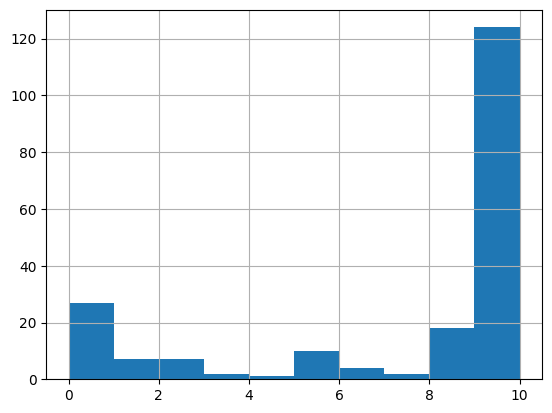

In [69]:
df_run["metric_llmrelevance_score"].hist()

In [87]:
threshold = 5
y_pred = df_run["metric_llmrelevance_score"] > 5
y_true = df_run["metric_presentationmatch_score"]


Precision:0.8513513513513513
Recall: 0.9333333333333333


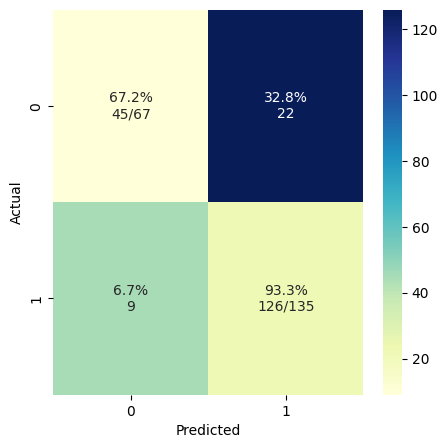

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def plot_cm(y_true, y_pred, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i][0]
                annot[i, j] = f"{p:.1f}%\n{c}/{s}"
            elif c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = f"{p:.1f}%\n{c}"
    cm = pd.DataFrame(reversed(cm),)
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        cm, cmap= "YlGnBu", annot=annot, fmt="", ax=ax,
    )

plot_cm(y_true, y_pred)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"Precision:{precision}")
print(f"Recall: {recall}")

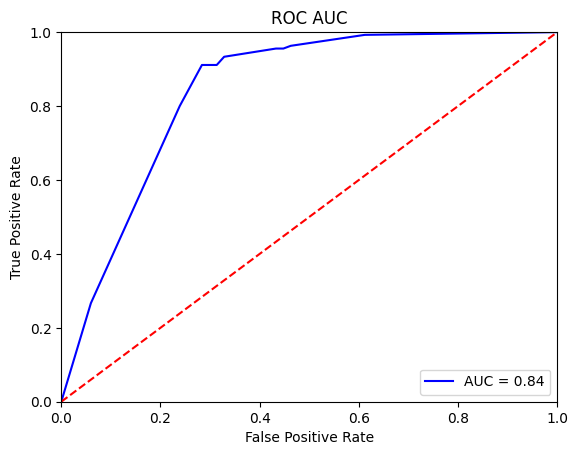

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
y_pred = df_run["metric_llmrelevance_score"]
y_true = df_run["metric_presentationmatch_score"]

probs = y_pred
fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)


plt.title('ROC AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

,artifact_path,run_id,roc_auc,std,runName,preprocessing,artifact_uri,mean_presentationcount,mean_presentationidx,mean_bestchunkmatch,mean_pagefound,mean_llmrelevance,mean_pagematch,error_rate,mean_presentationmatch,n_questions,mean_presentationfound,scorer
4,/home/groot/Desktop/projects/global/PresRAG/pr...,7199da4de00b428c8f744fb513ba1eeb,0.907373,3.706234,scorer_min__retriever_presentationretriever__p...,None,file:///home/groot/Desktop/projects/global/Pre...,10.896040,2.304348,0.202970,0.782178,6.693069,0.594059,0.0,0.623762,202.0,0.910891,min
8,/home/groot/Desktop/projects/global/PresRAG/pr...,f088c46ec3864d678527389eedd3c2e9,0.902814,3.584268,scorer_exponential_a0.7_w1.7_s2.8__retriever_p...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.113861,1.923077,0.346535,0.787129,6.846535,0.599010,0.0,0.653465,202.0,0.900990,exponential
2,/home/groot/Desktop/projects/global/PresRAG/pr...,8e395bc634de4fdc8d5675635810ce43,0.890873,3.723168,scorer_weighted__retriever_presentationretriev...,None,file:///home/groot/Desktop/projects/global/Pre...,10.896040,2.548913,0.212871,0.782178,6.465347,0.594059,0.0,0.554455,202.0,0.910891,weighted
7,/home/groot/Desktop/projects/global/PresRAG/pr...,5bbf58bb439a40d4b4bd4b7762afd939,0.884305,3.503244,scorer_weighted__retriever_presentationretriev...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.108911,1.983516,0.366337,0.787129,6.896040,0.599010,0.0,0.638614,202.0,0.900990,weighted
9,/home/groot/Desktop/projects/global/PresRAG/pr...,b97c8d60d8314d958209ee601a070147,0.879411,3.415474,scorer_min__retriever_presentationretriever__p...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.118812,1.873626,0.361386,0.787129,7.034653,0.599010,0.0,0.688119,202.0,0.900990,min
6,/home/groot/Desktop/projects/global/PresRAG/pr...,fdb69b2939ca40e68304fa18fa17aa3e,0.879004,3.569064,scorer_hyperbolicweighted_k2.0_p3.0__retriever...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.108911,2.027473,0.361386,0.787129,6.886139,0.599010,0.0,0.653465,202.0,0.900990,hyperbolicweighted
5,/home/groot/Desktop/projects/global/PresRAG/pr...,73ca49f2e580489193e38c3573f68912,0.877481,3.630582,scorer_exponentialweighted_a0.7_w1.7_s2.8__ret...,Regex,file:///home/groot/Desktop/projects/global/Pre...,9.113861,2.043956,0.336634,0.787129,6.623762,0.599010,0.0,0.613861,202.0,0.900990,exponentialweighted
0,/home/groot/Desktop/projects/global/PresRAG/pr...,660c3ebd3cd145e89815eb31c33c125a,0.853606,3.718123,scorer_exponentialweighted_a0.7_w1.7_s2.8__ret...,None,file:///home/groot/Desktop/projects/global/Pre...,10.896040,2.836957,0.202970,0.782178,6.594059,0.594059,0.0,0.539604,202.0,0.910891,exponentialweighted
1,/home/groot/Desktop/projects/global/PresRAG/pr...,9b971822ff3f47978a66b27c323e1ff5,0.842565,3.561036,scorer_hyperbolicweighted_k2.0_p3.0__retriever...,None,file:///home/groot/Desktop/projects/global/Pre...,10.900990,2.092391,0.212871,0.782178,7.024752,0.594059,0.0,0.668317,202.0,0.910891,hyperbolicweighted
3,/home/groot/Desktop/projects/global/PresRAG/pr...,d974d8d0ed414efe86188db488c7f3b0,0.833555,3.622027,scorer_exponential_a0.7_w1.7_s2.8__retriever_p...,None,file:///home/groot/Desktop/projects/global/Pre...,10.896040,2.510870,0.217822,0.782178,6.826733,0.594059,0.0,0.603960,202.0,0.910891,exponential


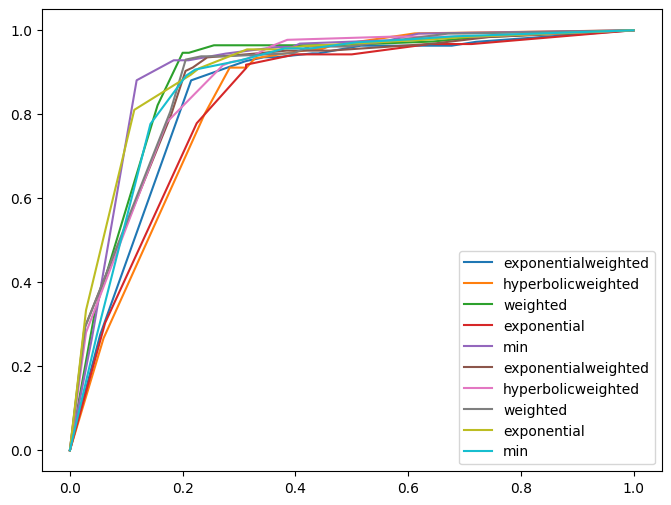

In [119]:
import matplotlib.pyplot as plt
from functools import partial

def calc_llm(artifact_uri, ax):
    artifact_path = Path(artifact_uri.split("file://")[1])

    csv_paths = list(artifact_path.rglob("*.*"))
    csv_path = csv_paths[0]
    run_id = str(artifact_path).split("/")[-2]

    df_run = pd.read_csv(csv_path)

    y_pred = df_run["metric_llmrelevance_score"]
    y_true = df_run["metric_presentationmatch_score"]

    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{run_id} (AUC = {roc_auc:.2f})")

    std = y_pred.std()
    return dict(
        artifact_path=artifact_path,
        run_id=run_id,
        roc_auc=roc_auc,
        std=std,
    )

fig, ax = plt.subplots(figsize=(8, 6))
calc_llm_ax = partial(calc_llm, ax=ax)

df_runs_llm = (
    df_runs["artifact_uri"]
    .apply(calc_llm_ax)
    .apply(pd.Series)
    .join(df_runs, how="left")
)

ax.legend(labels=df_runs_llm["scorer"].values)

df_runs_llm.sort_values("roc_auc", ascending=False)